In [1]:
import sys, os, torch, torchvision
import numpy as np
sys.path.append('/mfs/haoyu/project/CDCNN/ICNN/Official_Model_For_Paper/ModelTraining/TwoStep_Algorithm1_Clip')
from resnet_std import resent as resnet_std
from resnet_std import ResNet
from VOCPart import VOCPart
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device_str = "cuda:0"
device = torch.device(device_str)

In [2]:

ResNet.forward = ResNet.get_feature_map

exp_dir = { 'LSG': '/mfs/haoyu/project/CDCNN/ICNN_exp/VOCPart_train0.7_128_pretrained/res152_bs32_adam_lr1e-3_lrreg1e-3_lmd1e-3_frozen_6:2',
            'naive' : '/mfs/haoyu/project/CDCNN/ICNN_exp/VOCPart_train0.7_128_pretrained/naive_res152_bs32_adam_lr1e-5'}

model = {} 
for method in ['LSG', 'naive']:
    ifmask = method == 'LSG'
    model[method] = resnet_std(depth=152, num_classes=6, pretrained=True, ifmask=ifmask)
    model[method] = model[method].to(device)
    model[method] = torch.nn.DataParallel(model[method]) # device_ids=args.gpu_ids
    # patch_replication_callback(model)
    unfinished_model_path = os.path.join(exp_dir[method] , 'unfinished_model_110.pt')
    checkpoint = torch.load(unfinished_model_path,map_location={'cuda:0': device_str})
    model[method].load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']+1
# loss = checkpoint['loss']


mask (2048, 6)


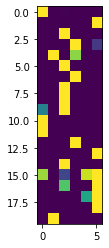

In [3]:
mask = model['LSG'].module.lmask.mask.detach().cpu().numpy()
print('mask',mask.shape)
from matplotlib import pyplot as plt
plt.imshow(mask[0:20,:])
plt.show()

num_channel, num_class = mask.shape

In [4]:
dataset = VOCPart('/home/haoyu/data/VOCPart', train=False, requires=['img'], size=128)
dataloader = torch.utils.data.DataLoader(dataset,
                batch_size=32, pin_memory=True,
                shuffle=False, num_workers=16)

threshold_probability = 0.05  #  0.005
num_large = int( threshold_probability * 4 *4 * len(dataset) )


# class Largest(object):
#     def __init__(self, size):
#         self.largests = []
#         self.size= size
#     def add(self, x):
#         if  len(self.largests)<self.size:
#             self.largests.append(x)
#             self.largests=sorted(self.largests)
#         elif x > self.largests[0]:
#             self.largests[0]=x
#             self.largests=sorted(self.largests)
#     def smallest(self):
#         return self.largests[0]
threshold = {}
for method in ['LSG', 'naive']:
    activations = np.zeros((num_channel, len(dataset)*16))

    # largests = Largest(num_large)
    # for x in range(1000):
    #     largests.add(x)

    # largsest = [Largest(num_large) for i in range(num_channel)]

    for batch_id, (imgs, labels) in enumerate(dataloader):
        
        fmap = model[method](imgs)
        bs, n_channel, _, _ =fmap.shape
        fmap = fmap.view(bs, n_channel, -1)

        activations_channels = torch.cat((*fmap, ), 1) # num_channel, batch_size * 16

        activations[:, (batch_id*bs*16):((batch_id+1)*bs*16)] = activations_channels.detach().cpu().numpy()
    
        print(method,'img_num =', batch_id * bs, end='\r')
        # for channel, activations in enumerate(activations_channels):
        #     # print('activations.shape',activations.shape)
        #     for x in activations:
        #         x = x.item()
        #         # print(type(x),x)
        #         largsest[channel].add(x)
        #     # break
        # # break
    activations_sort = np.sort(activations, axis=1)
    threshold[method] = activations_sort[:,-num_large]

print()
print(threshold['LSG'])
print(threshold['naive'])
# activations.size()

val set
image size 128x128
image num = 1700
naive img_num = 212
[4.49162149 1.39210093 3.2163949  ... 0.924703   0.69000798 0.87709999]
[2.6833868  2.03313327 3.28682542 ... 1.79447234 1.5588336  1.78139877]


In [5]:
dataset = VOCPart('/home/haoyu/data/VOCPart', train=False, requires=['img','obj_mask', 'part_mask'], size=128)
dataloader = torch.utils.data.DataLoader(dataset,
                batch_size=32, pin_memory=True,
                shuffle=False, num_workers=16)

val set
image size 128x128
image num = 1700


In [6]:
num_class = 6
# threshold = 1
UoI_threshold = 0.04
# num_class = 6
# num_channel = 2048

def dev_zero_replace(a,b):
    return np.divide(a, b,
             out=np.zeros_like(a/1.0),
             where=(b!=0))


def get_IoU(fmap, obj_mask, _threshold):
    # 皆是 torch.tensor(1,128,128)

    # fmap = fmap[0]

    # print('fmap', fmap.shape)
    # plt.imshow(fmap, cmap='gray')
    # plt.show()


    fmap = torch.nn.functional.interpolate(fmap.view(1,1,4,4), 128, mode='bilinear', align_corners=False) [0]
    # print('fmap', fmap.shape)

    fmap = fmap[0]
    obj_mask = obj_mask[0]    

    # plt.imshow(fmap, cmap='gray')
    # plt.show()

    # plt.imshow(obj_mask, cmap='gray')
    # plt.show()

    # print('fmap max=',fmap.max(), 'min=',fmap.min())
    # print('obj_mask max=',obj_mask.max(), 'min=',obj_mask.min())

    # print('obj_mask.dtype=',obj_mask.dtype)
    fmaask=(fmap >= _threshold).float()
    # print('fmaask.dtype=',fmaask.dtype)

    # print('fmaask max=',fmaask.max(), 'min=',fmaask.min())
    # plt.imshow(fmaask, cmap='gray')
    # plt.show()

    union = torch.max(fmaask,obj_mask)
    # plt.imshow(union, cmap='gray')
    # plt.show()

    intersect = torch.min(fmaask,obj_mask)
    # plt.imshow(intersect, cmap='gray')
    # plt.show()

    _UoI = intersect.sum()/union.sum()
    # print('IoU =', _UoI)

    return _UoI.item()


pbar = tqdm(bar_format='{desc}') 

sum = {'LSG': np.zeros(mask.shape), 'naive' :  np.zeros(mask.shape)}
num = {'LSG': np.zeros(mask.shape), 'naive' :  np.zeros(mask.shape)}
mean_score_filter = {'LSG': 0.0, 'naive' : 0.0}

for img_id,(img, label, obj_mask, part_mask) in enumerate(dataset):
    # print(label )
    # print(*img.shape)
    img = img.view(1,*img.shape).to(device)
    for method in ['LSG', 'naive']:
        feature_map = model[method](img)[0].detach().cpu()

        for channel, fmap in enumerate(feature_map):

            fmap = fmap
            # print('feature_map', feature_map.shape)
            
            IoU = get_IoU(fmap, obj_mask, threshold[method][channel])
            # print('IoU =', IoU)

            sum[method][channel, label] += int(IoU>UoI_threshold)
            num[method][channel, label] += 1

            # if channel == 11:
            #     break
        #     break
        # break

        meanIoU = dev_zero_replace(sum[method], num[method])
        score_filter = meanIoU.max(axis=1)
        mean_score_filter[method] = score_filter.mean()
        
    pbar.set_description_str('img_num %6d  mean_score_filter LSG : naive = %5f : %5f' % (img_id, mean_score_filter['LSG'], mean_score_filter['naive']) )
    pbar.update()





# meanIoU = sum/num



img_num   1699  mean_score_filter LSG : naive = 0.528442 : 0.049774

In [6]:
pbar.close()


img      4  mean_score_filter LSG : naive = 0.418620 : 0.672201


In [26]:
related_filter_num = {}
related_filter_mean_score = {}

for method in ['LSG', 'naive']:
    meanIoU = dev_zero_replace(sum[method], num[method])
    score_filter = meanIoU.max(axis=1)
    filter_related_class = meanIoU.argmax(axis=1)
    related_filter_num[method]=np.zeros(num_class)
    related_filter_mean_score[method]=np.zeros([num_class])
    for cid, class_name in enumerate(dataset.classes):
        score_related_to_class = score_filter[filter_related_class==cid]
        related_filter_num[method][cid] = len(score_related_to_class)
        related_filter_mean_score[method][cid] = score_related_to_class.mean() 

print(*dataset.classes, sep=',')
for method in ['LSG', 'naive']:
    print(method)
    print('related_filter_num',*related_filter_num[method], sep=',')
    print('related_filter_mean_score',*related_filter_mean_score[method], sep=',')
    print('average_score', (related_filter_num[method]*related_filter_mean_score[method]).sum() / related_filter_num[method].sum() , sep=',')

bird,cat,dog,cow,horse,sheep
LSG
related_filter_num,198.0,351.0,899.0,166.0,266.0,168.0
related_filter_mean_score,0.4227321445970964,0.4312945671327174,0.6889643200965696,0.4045700041545492,0.36130374479889044,0.3840495547812622
average_score,0.5284423942724791
naive
related_filter_num,284.0,351.0,291.0,351.0,381.0,390.0
related_filter_mean_score,0.04129115529187989,0.046917971773463095,0.0438182854853374,0.05389527458492976,0.05330887037178605,0.055805711903272874
average_score,0.049774495070727474
